# Selection of number of filters and kernel size in convolutional layers


To study the impact of the kernel size and the initial number of filters in the UNet model on the segmentation quality and to choose the optimal value.


* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)



### The parameters studied

Kernel size and number of filters in the first convolutional layer (the subsequent layers have twice the number of filters in relation to the previous layer).

### Parameters Value Area
* __A number of filters in the first convolutional layer::__ 4, 12, 32
* __Kernel size:__ 3х3, 5x5


### Metrics
The average value of the IOU (intersection over union) on the test set.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np

from batchflow import Pipeline, B, V, C, F, L, NumpySampler as NS
from batchflow.opensets import MNIST
from batchflow.models.tf import UNet
from batchflow.research import Option, Research, Results

from src import MnistBatch, show_research, show_samples

%env CUDA_VISIBLE_DEVICES='6,7'

env: CUDA_VISIBLE_DEVICES='6,7'


# Dataset loading

For training and model performance assessment we generate images of shape 60x60 on which a MNIST digit is randomly located. Also we add random noise cropped from other MNIST images.

A label data for every image is a binary array of the same shape as an image with the value "1" if the corresponding pixel on the image represents mnist image rectangle and value "0" otherwise.

Data is generated on each iteration of training and test pipelines.

Load original MNIST dataset:

In [2]:
mnist_ds = MNIST(batch_class=MnistBatch)

A position of mnist image's bottom left corner is randomly sampled from [2, 40].

Create uniform sampler to generate random digit positions:

In [3]:
SHAPE = 60

In [4]:
ns = NS('uniform', dim=2, low=2, high=(SHAPE - 20)).apply(lambda s: s.astype(np.int))

Define preprocessing pipeline which consists of:
* Creating a 60x60 image with a MNIST image located in a random position.
* Adding noise cropped from other images in the batch.


In [5]:
prep_pipeline = (Pipeline()
                 .create_big_img(coord=L(ns.sample)(size=F(len)), 
                                 shape=SHAPE, 
                                 src=['images', 'labels'], 
                                 dst=['big_img', 'masks'])
                 .add_noize(num_parts=50)
                 .to_array(src='masks', dst='masks')
                 .to_array(src='big_img', dst='big_img')
)

Examples of dataset items (top row) and corresponding labels (bottom row):

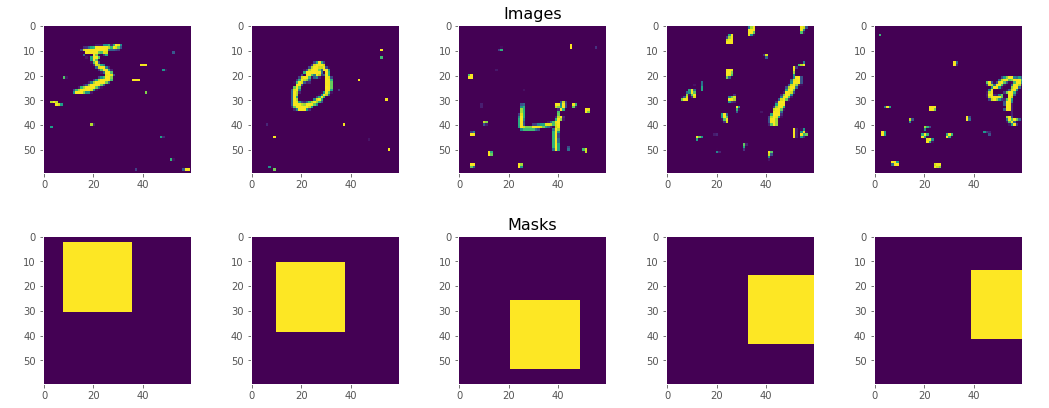

In [6]:
batch = (prep_pipeline << mnist_ds.train).next_batch(5)
show_samples([batch.big_img[:, :, :, 0], batch.masks[:, :, :, 0]], row_titles=['Images', "Masks"])

# Creating a model template

We use UNet model with number of blocks NUM_BLOCKS = 3 and different number of filters in the first convolutional layer.

In [7]:
NUM_BLOCKS = 3

In [8]:
model_config = {
        'inputs/images/shape': tuple([SHAPE, SHAPE, 1]),
        'inputs/masks/shape': tuple([SHAPE, SHAPE, 1]),
        'initial_block/inputs': 'images',
    
        'initial_block/filters': C('initial_block_filters'), 
        'initial_block/kernel_size': C('kernel_size'),
        'body/encoder/num_stages': NUM_BLOCKS - 1,
        'body/encoder/blocks/filters': C('encoder_filters'), 
        'body/encoder/blocks/kernel_size': C('kernel_size'),
        'body/decoder/blocks/filters': C('decoder_filters'),
        'body/decoder/blocks/kernel_size': C('kernel_size'),
        'head/filters': C('initial_block_filters'),
        'head/kernel_size': C('kernel_size'),
    
        'loss': 'bce',
        'optimizer': 'Adam',
        'output': ['sigmoid']
}

Define train and test pipeline and set parameters of lazy run with BATCH_SIZE = 40:

In [9]:
BATCH_SIZE = 40

In [10]:
train_pipeline = ((prep_pipeline << mnist_ds.train)
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet',
                              config=model_config)
                  .train_model('unet', 
                               fetches='loss', 
                               images=B('big_img'), masks=B('masks'),
                               save_to=V('loss'))
                  .run_later(BATCH_SIZE, n_epochs=None)
)

test_pipeline = ((prep_pipeline << mnist_ds.test)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .import_model('unet', C('import_from'))
                 .predict_model('unet', fetches='sigmoid', 
                                images=B('big_img'),
                                save_to=V('predictions'))
                 .gather_metrics('segmentation',
                                 targets=B('masks'),
                                 predictions=V('predictions'),
                                 fmt='proba', save_to=V('metrics', mode='w'))
                 .run_later(BATCH_SIZE, n_epochs=None)
)

# Creating a research object

Set the parameters for research execution:

For each parameter set perform NUM_ITERS=450 iterations of train pipeline with model performance evaluation every single iteration. Repeat this procedure NUM_REPEAT=4 times.

Results of the research execution will be saved in the directory __two_hyper_research__

In [11]:
ibf = [4, 12, 32]

opts = (Option.product(Option('initial_block_filters', ibf), 
                      Option('encoder_filters', [[f0 * 2* 2**i for i in range(NUM_BLOCKS - 1)] for f0 in ibf]),
                      Option('decoder_filters', [[f0 * 2**i for i in range(NUM_BLOCKS - 2, -1, -1)] for f0 in ibf]))
       * Option('kernel_size', [3, 5]))
list(opts.gen_configs())

[ConfigAlias({'decoder_filters': '[8, 4]', 'initial_block_filters': '4', 'kernel_size': '3', 'encoder_filters': '[8, 16]'}),
 ConfigAlias({'decoder_filters': '[8, 4]', 'initial_block_filters': '4', 'kernel_size': '5', 'encoder_filters': '[8, 16]'}),
 ConfigAlias({'decoder_filters': '[24, 12]', 'initial_block_filters': '12', 'kernel_size': '3', 'encoder_filters': '[24, 48]'}),
 ConfigAlias({'decoder_filters': '[24, 12]', 'initial_block_filters': '12', 'kernel_size': '5', 'encoder_filters': '[24, 48]'}),
 ConfigAlias({'decoder_filters': '[64, 32]', 'initial_block_filters': '32', 'kernel_size': '3', 'encoder_filters': '[64, 128]'}),
 ConfigAlias({'decoder_filters': '[64, 32]', 'initial_block_filters': '32', 'kernel_size': '5', 'encoder_filters': '[64, 128]'})]

In [12]:
research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test', execute=10, run=False,
                          import_from='train', variables='metrics')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='iou',
                         returns='iou', execute=10)
            .add_grid(opts))

Run research:

In [13]:
N_REPS = 4
N_ITERS = 450

In [15]:
research_name = 'two_hyper_research'
research.run(n_reps=N_REPS, n_iters=N_ITERS, name=research_name, bar=True,  workers=2, gpu=[6,7])

Research two_hyper_research is starting...


  0%|          | 0/10800 [00:00<?, ?it/s]

Distributor has 24 jobs with 450 iterations. Totally: 10800


100%|██████████| 10800/10800 [34:53<00:00,  5.16it/s]


## Results

In [16]:
df = Results(path=research_name).load(use_alias=True)

Train loss and test IOU vs a number of iterations for each parameters set:

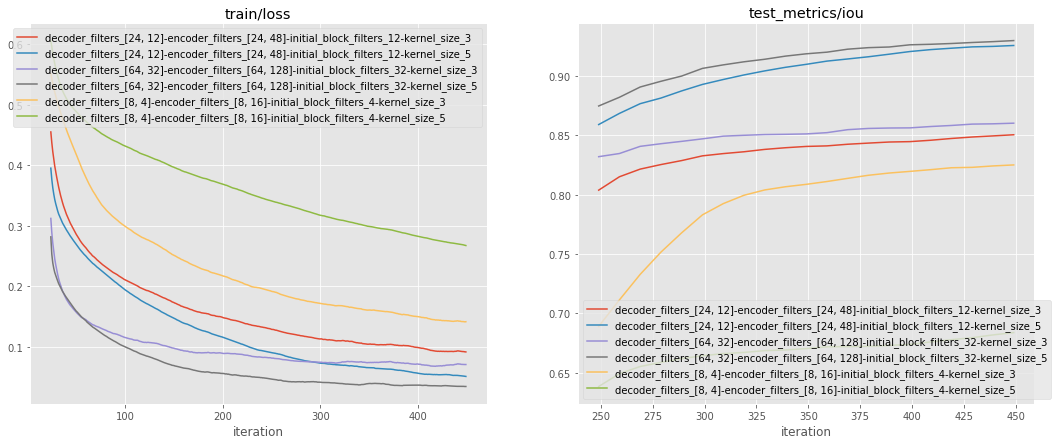

In [17]:
show_research(df, layout=['train/loss', 'test_metrics/iou'], average_repetitions=True, rolling_window=25)

In [25]:
res = research.load_results(names='test_metrics', iterations=449)
res.groupby(['initial_block_filters', 'kernel_size'])['iou'].mean()

initial_block_filters  kernel_size
12                     3              0.855303
                       5              0.937020
32                     3              0.854832
                       5              0.941172
4                      3              0.822467
                       5              0.714266
Name: iou, dtype: float64

## Conclusion

We can see that models with kernel size 5 tend to perform better than models with kernel size 3, exept when `initial_block_filters == 4`, therefore increasing the kernel size gives a greater effect than increasing the number of filters.

Model configurations `{'initial_block_filters': '12', 'kernel_size': '5'}` and `{'initial_block_filters': '32', 'kernel_size': '5'}` have higher average iou, `{'initial_block_filters': '32', 'kernel_size': '5'}` being slightly better. Configuration choice therefore depends on available resources.

Recommended values: __The initial number of filters 32 with a kernel size of 5 .__
